<a href="https://colab.research.google.com/github/vaipatel/udacity_robond_2020/blob/master/Monte_Carlo_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Localization

Monte Carlo Localization or MCL is a localization algo that relaxes several restrictive assumptions made in Kalman Filters. For example

* Dynamics need not be linear.
* Dynamics noise need not be additive Gaussian.
* Observation (measurement) noise need not be additive Gaussian.

MCL uses [Particle Filters](https://en.wikipedia.org/wiki/Particle_filter) which is a type of non-parametric [Recursive Bayesian Filter](https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation).
* Non-parametric because we never keep a parametric model of the desired density, instead using the collective states of particles to implicitly and approximately represent the true density of our robot state.
* [Recursive Bayes](https://en.wikipedia.org/wiki/Particle_filter#The_nonlinear_filtering_equation) because the uncorrected belief over the current state is
  * recursively obtained from the corrected belief over the previous state using the dynamics model
  * bayesianly corrected using sensor measurement/observation model
  
  just like we do in Kalman Filters.
  
  The difference here is that in Kalman Filters we have easy (linear, Gaussian) closed-form expressions for the dynamics model as well as the observation model. 

  Here we don't have access to any such closed-form models. Instead, the prediction is obtained by having the particles perform the action (motion), and the correction update is an importance sampling of the moved particles wherein the more likely particles tend to survive so that we have adjusted our state prediction with our measurements.

## Pros and Cons

The big pro is that MCL can model arbitrary distributions.

The big con is that MCL is impractical for high dimensional states because of the number of particles needed to sufficiently sample the state space.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats # Only used for norm.pdf()

np.random.seed(1234);

## MCL Algo ingredients

### Robot

Our robot will be able to accept commands to move and sense its environment. The execution of these commands will involve some noise. But whereas in Kalman Filters we assume Gaussian noise and linear dynamics, MCL poses no such restrictions. Kalman Filters work with an explicit model of noise which makes calculations very easy but makes the technique restrictive, whereas MCL does not assume an explicit model of the noise at all.

In [0]:
class Robot:
  """A Robot that can noisy move, noise sense distances to 8 lmks around the 
  world, store its trajectory, and calculate the likelihood of a measurement
  given the current pose state."""

  def __init__(self, world_size=2):
    self.world_size = world_size
    # Util
    self.twopi = 2*np.pi
    # Loc, Orient
    self.x = np.random.rand()*world_size
    self.y = np.random.rand()*world_size
    self.orient = np.random.rand()*(self.twopi)
    # Noise
    self.sensor_noise = 0
    self.forward_noise = 0
    self.turn_noise = 0
    # Create lmks
    self.n_lmks = 8
    self.lmks = self._gen_lmks(0.8)
    self.traj = [self.exact_loc()]

  def set_noise(self, sensor_noise=1, forward_noise=0.5, turn_noise=0.05):
    """Sets noise std dev levels for measurement and motion."""
    self.sensor_noise = sensor_noise
    self.forward_noise = forward_noise
    self.turn_noise = turn_noise

  def move(self, angle, fwd):
    """Performs noisy move (turn and forward) on the robot."""
    if (fwd < 0):
      raise ValueError("fwd must be non-negative.")
    angle = (angle + np.random.randn()*self.turn_noise) % (self.twopi)
    self.orient = (self.orient + angle) % (self.twopi)
    fwd = fwd + np.random.randn()*self.forward_noise
    self.x = np.mod((self.x + fwd*np.cos(self.orient)), self.world_size)
    self.y = np.mod((self.y + fwd*np.sin(self.orient)), self.world_size)
    # Add to traj
    self.traj.append(self.exact_loc())

  def sense_perfect(self):
    """Performs noiseless measurement."""
    return np.sqrt(np.sum(np.square(self.exact_loc() - self.lmks), axis=1))

  def sense(self):
    """Performs a noisy measurement. Intuitively, this can only arrive via 
       actual sensor. So, for eg, a virtual particle should never call sense().
    """
    dists = self.sense_perfect()
    dists = dists + np.random.randn(self.n_lmks)*self.sensor_noise
    return dists

  def measurement_prob(self, z):
    """Calculates p(z|x,y), the likelihood of a measurement z given the loc
       state (x,y)."""
    pdfs = scipy.stats.norm(loc=self.sense_perfect(), scale=self.sensor_noise).pdf(z)
    return np.prod(pdfs)

  def exact_loc(self):
    """Returns the exact location. This can be used in noiseless calculations,
       like sense_perfect() or print_pose()."""
    return np.array([self.x, self.y])

  def exact_traj(self):
    """Returns exact trajectory"""
    return np.array(self.traj)

  def print_pose(self):
    """Prints current pose info. Of course print_pose() is noiseless."""
    print("(x,y):", self.exact_loc(), "ang_deg:", np.rad2deg(self.orient))

  def _gen_lmks(self, lmks_scale=0.8):
    """Generates 8 landmarks around the world and brings them in by lmks_scale.
    """
    w = self.world_size
    lmks = np.array([(0,0), (0.5*w, 0), (w, 0), (w, 0.5*w), (w, w), (0.5*w, w), (0, w), (0, 0.5*w)])
    lmks = (lmks - np.mean(lmks))*lmks_scale + np.array([w,w])*0.5
    return lmks

  def plot_traj(self, fig, ax, init_col='ro', arrow_col='black', stop=None):
    """Plots robot traj."""
    if stop == None or stop < 1 or stop > len(self.traj):
      stop = len(self.traj)
    for i in range(1, stop):
      delta_loc = self.traj[i] - self.traj[i - 1]
      ax.arrow(self.traj[i-1][0], self.traj[i-1][1], delta_loc[0], delta_loc[1], head_width=0.15, color=arrow_col)
      # plt.plot(self.traj[i][0], self.traj[i][1], 'ro')
    ax.plot(self.traj[stop-1][0], self.traj[stop-1][1], init_col, markerfacecolor='None')
    ax.axis([0, self.world_size, 0, self.world_size])
    ax.set_aspect('equal')
    #fig.tight_layout()#([0, WORLD_SIZE, 0, WORLD_SIZE])

  def _gauss_pdf(self, mu, sigma, x):
    """Calculates p(x) where p ~ N(mu,sigma), or equivalently N(x|mu,sigma)."""
    return scipy.stats.norm(loc=mu, scale=sigma).pdf(x)
    #return np.exp( - np.square(x - mu) / 2*np.square(sigma) )/(sigma * np.sqrt(2 * np.pi))

### Particle

A Particle is like a virtual robot, but the difference is that a particle is "our" creation. 

That is, we have perfect information about the state of a particle, and we can make perfect measurements because **we have a map of the environment in which we generate particles** - this is an underlying but perhaps easily forgotten point about the Localization problem.

For eg, in our scenario we have perfect information about the exact locations of the landmarks (environment) and we have perfect information about the states of the particles that we generate. So we can make perfect measurements for every particle (which are just the euclidean distances between that particle and all the landmarks).

We will exploit this knowledge to iteratively resample particles for whom the robot's measurements are more likely, and will hope to be left with particles whose states are quite close to robot's true state.

In [0]:
class Particle(Robot):
  def __init__(self, o, to_o_pose=False):
    super().__init__(world_size=o.world_size)
    if to_o_pose:
      self.x = o.x
      self.y = o.y
      self.orient = o.orient
      # If we don't reset to o's pose, then self.traj will not need fixing.
      self.traj=[self.exact_loc()]
    self.set_noise(o.sensor_noise, o.forward_noise, o.turn_noise)

### MCL Algo

We use particles for the MCL algo.

In particular we make several uniform-randomly dispersed particles, move them in tandem with the robot, calculate how likely each particle's state is given what the robot senses, and spawn new particles with spawn probabilities proportional to the likelihoods of the old particles.

Over time (if things go well) the particles tend to converge near the robot's true state.

In [0]:
class MCL:
  def __init__(self, robot, n_particles=10, particle_sensor_noise=5,
               particle_fwd_noise=0.05, particle_turn_noise=0.05):
    self.robot = robot
    self.n_particles = n_particles
    self.particle_sensor_noise = particle_sensor_noise
    self.particle_fwd_noise = particle_fwd_noise
    self.particle_turn_noise = particle_turn_noise

    # Init particles
    self._recreate_particles()
    self._reset_particle_noise()
    self.stored_particles = [self.particles]

  def _recreate_particles(self):
    self.particles = [Particle(o=self.robot) \
                      for i in range(self.n_particles)] 

  def _reset_particle_noise(self):
    for particle in self.particles:
      particle.set_noise(sensor_noise=self.particle_sensor_noise,
                         forward_noise=self.particle_fwd_noise,
                         turn_noise=self.particle_turn_noise)
      
  def _move(self, angle, fwd):
    """Noisy move all particles."""
    for particle in self.particles:
      particle.move(angle=angle, fwd=fwd)

  def _resample(self, weights):
    """Resample according to importance weights."""
    # Get n_particle random indices
    index = np.random.randint(0, self.n_particles, size=self.n_particles)
    # Fetch weights at random indices
    idxed_weights = weights[index]
    # Init beta to 2 times the maximum weight
    beta = 2.0*np.max(weights)*np.random.rand(self.n_particles)
    # Make bool arr to find which indexed weights are less than beta
    are_less = idxed_weights < beta
    # If there are still indexed weights less than beta
    while np.any(are_less):
      # Decrement betas that are more that weights.
      beta[are_less] -= idxed_weights[are_less]
      # Circular increment indices where weights were lesser than beta.
      index[are_less] = (index[are_less] + 1) % self.n_particles
      idxed_weights = weights[index]
      # Recheck if weights are still less than beta using fast vectorized comp.
      are_less = idxed_weights < beta
    # index should have indices of particles chosen (possibly multiply) from the
    # resampling process. Return the resampled particle copies.
    particles = [Particle(o=self.particles[index[i]], to_o_pose=True) \
                 for i in range(self.n_particles)]
    return particles

  def localize(self, angle, fwd, steps=10):
    """Run MCL by iteratively moving, weighting and sampling particles."""
    for step in range(steps):
      # Move robot
      self.robot.move(angle, fwd)

      # Move particles
      self._move(angle, fwd)
      
      # Make robot measurement
      robot_meas = self.robot.sense()

      # Set particle's importance weight as likelihood of robot measurement
      # given particle's state.
      weights = np.array([particle.measurement_prob(robot_meas) for particle in\
                          self.particles])
      
      # Resample particles based on their importance weights.
      self.particles = self._resample(weights)
      self.stored_particles.append(self.particles)

## Running the MCL Algo

Let's run the above MCL code on a toy problem.

### Global Vars

In [0]:
WORLD_SIZE = 10
INIT_MOVE_ANGLE = np.pi*0.5
INIT_MOVE_FWD = 0.5

ROBOT_SENSOR_NOISE = 1
ROBOT_FWD_NOISE = 0.15
ROBOT_TURN_NOISE = 0.15

NUM_PARTICLES = 80

PARTICLE_SENSOR_NOISE = 1
PARTICLE_FWD_NOISE = 0.15
PARTICLE_TURN_NOISE = 0.15

MCL_STEPS = 3*5 # Making it multiple of 3 for plotting purposes. Whatever.
N_PLOT_COLS = 3
N_PLOT_ROWS = int(np.ceil(MCL_STEPS/N_PLOT_COLS)) # Can just do int div.

### Create the robot

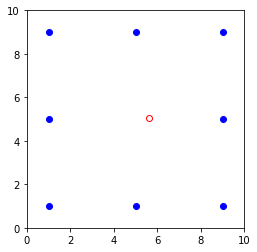

In [0]:
robot = Robot(WORLD_SIZE)
robot.set_noise(sensor_noise=ROBOT_SENSOR_NOISE,
                forward_noise=ROBOT_FWD_NOISE,
                turn_noise=ROBOT_TURN_NOISE)
#robot.move(angle=INIT_MOVE_ANGLE, fwd=INIT_MOVE_FWD)
fig, ax = plt.subplots(1,1)
plt.plot(robot.lmks[:,0], robot.lmks[:,1], 'bo')
robot.plot_traj(fig, ax)

### Create the MCL Algo object

This will handle creation of particles.

In [0]:
mcl = MCL(robot, n_particles=NUM_PARTICLES,
          particle_sensor_noise=PARTICLE_SENSOR_NOISE,
          particle_fwd_noise=PARTICLE_FWD_NOISE,
          particle_turn_noise=PARTICLE_TURN_NOISE)

### Run the MCL algo

In [0]:
mcl.localize(INIT_MOVE_ANGLE, INIT_MOVE_FWD, steps=MCL_STEPS)

### Plot the MCL Algo steps

This can help see how the particles converge near to the robot's actual state.

Warning: These can be quite slow.

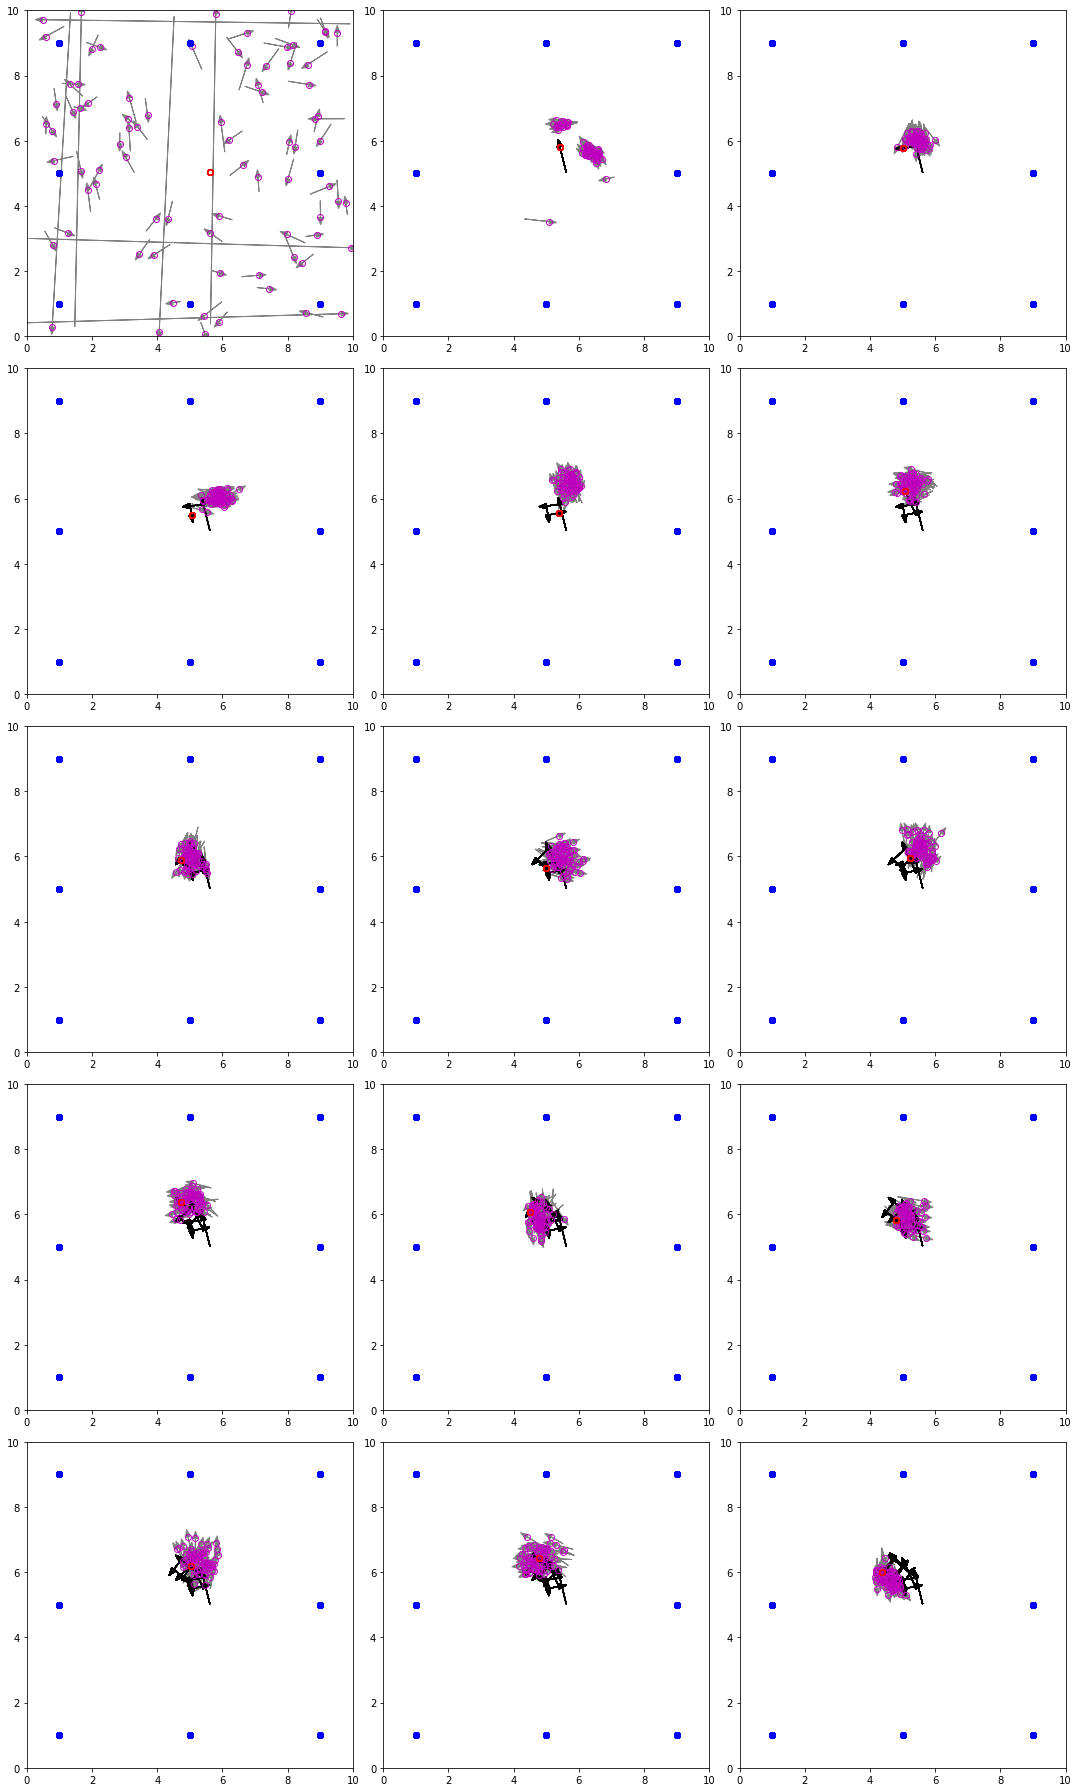

In [0]:
fig, ax = plt.subplots(N_PLOT_ROWS, N_PLOT_COLS,
                       figsize=(N_PLOT_COLS*5, N_PLOT_ROWS*5))

last_ax_i = 0
last_ax_j = 0
for i in range(N_PLOT_ROWS):
  for j in range(N_PLOT_COLS):
    idx = j + i*N_PLOT_COLS
    if idx == MCL_STEPS:
      last_ax_i = i
      last_ax_j = j
      break
    particles = mcl.stored_particles[idx]
    for particle in particles:
      particle.plot_traj(fig, ax[i,j], init_col='mo', arrow_col='grey')
      ax[i,j].plot(robot.lmks[:,0], robot.lmks[:,1], 'bo')
      robot.plot_traj(fig, ax[i,j], stop=idx + 1)
# for a in ax[last_ax_i:, last_ax_j:][0]:
#   a.remove()
fig.tight_layout()